In [1]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math

import numpy as np
from sklearn.cluster import KMeans

import torch
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear


/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## K-means

In [58]:
ori_data = pd.read_csv('../Model_memory/memory.csv')
ori_data

,episode,cart_position,cart_velocity,pole_angle,pole_angular_velocity,action,reward,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity,q_values
0,0,0.013870,0.026208,0.027376,0.033123,1,1.0,0.014394,0.220927,0.028038,-0.250798,"[17.424397, 18.431095]"
1,0,0.014394,0.220927,0.028038,-0.250798,1,1.0,0.018813,0.415638,0.023022,-0.534507,"[17.785023, 18.40013]"
2,0,0.018813,0.415638,0.023022,-0.534507,0,1.0,0.027126,0.220200,0.012332,-0.234660,"[18.670609, 18.5435]"
3,0,0.027126,0.220200,0.012332,-0.234660,1,1.0,0.031530,0.415143,0.007639,-0.523427,"[17.776121, 18.367172]"
4,0,0.031530,0.415143,0.007639,-0.523427,0,1.0,0.039833,0.219915,-0.002830,-0.228347,"[18.685854, 18.484688]"
...,...,...,...,...,...,...,...,...,...,...,...,...
357454,359,-2.353374,-0.355497,-0.152123,-0.519090,0,1.0,-2.360484,-0.548187,-0.162505,-0.277945,"[16.880257, 16.365782]"
357455,359,-2.360484,-0.548187,-0.162505,-0.277945,1,1.0,-2.371447,-0.351165,-0.168064,-0.617151,"[16.847618, 17.038782]"
357456,359,-2.371447,-0.351165,-0.168064,-0.617151,0,1.0,-2.378471,-0.543590,-0.180407,-0.381759,"[14.859798, 13.617133]"
357457,359,-2.378471,-0.543590,-0.180407,-0.381759,0,1.0,-2.389343,-0.735753,-0.188042,-0.150944,"[15.455376, 15.313276]"


In [60]:
# how many reward = 0
len(ori_data['reward'])-sum(ori_data['reward'])

1120.0

In [61]:
zero_rew = ori_data[ori_data['reward'] == 0]

In [62]:
one_rew = ori_data[ori_data['reward'] == 1].sample(1120*5)
ori_data = pd.concat([zero_rew, one_rew])
ori_data.shape

(6720, 12)

In [13]:
data = ori_data[['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']]
data

,cart_position,cart_velocity,pole_angle,pole_angular_velocity
104,1.472014,3.022731,-0.206378,-2.824556
172,0.807480,2.512567,-0.170164,-2.521953
258,1.286427,2.846230,-0.177349,-2.687675
372,1.962133,3.630681,-0.162776,-3.126369
461,1.321149,3.063333,-0.176627,-2.929144
...,...,...,...,...
2648,0.141579,0.306412,0.104700,0.311679
3630,0.832509,0.935115,0.069643,0.057704
7595,0.871737,0.734859,-0.000990,0.179033
6810,0.572105,0.507716,-0.025008,-0.021689


/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


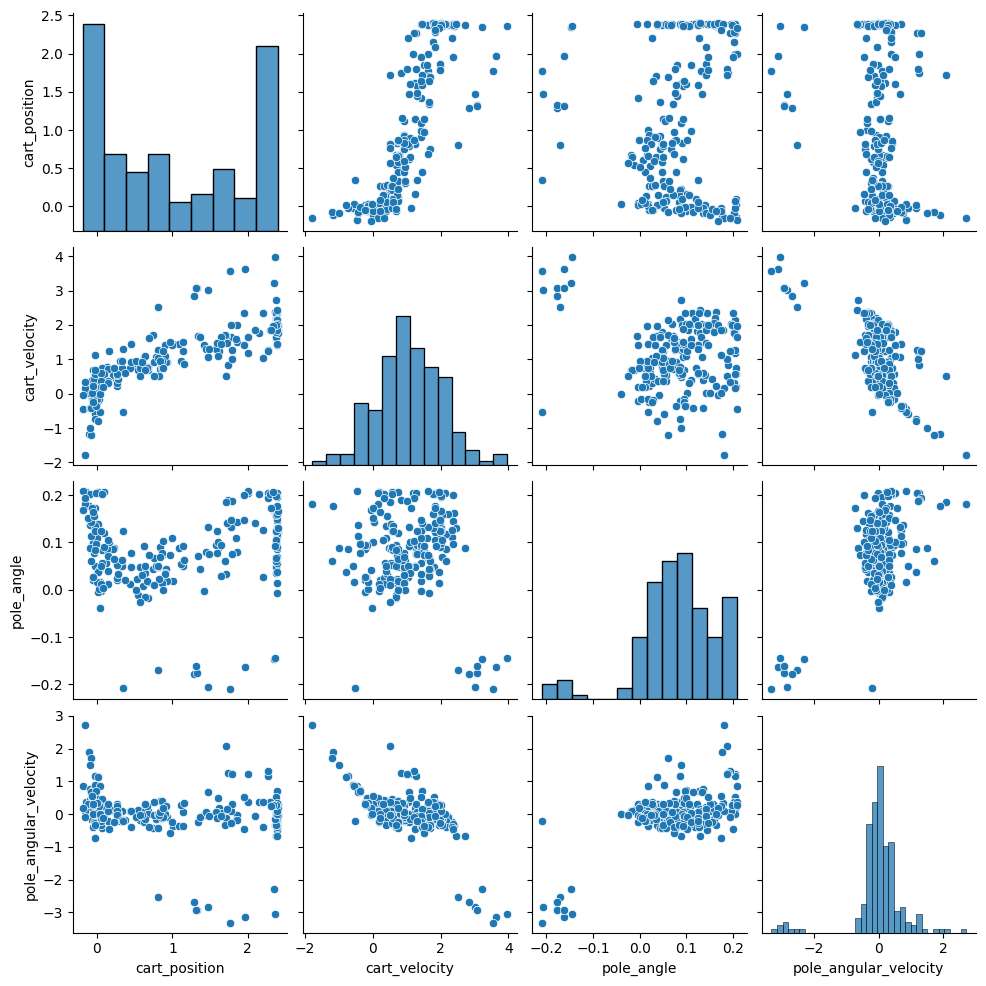

In [14]:
sns.pairplot(data)

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

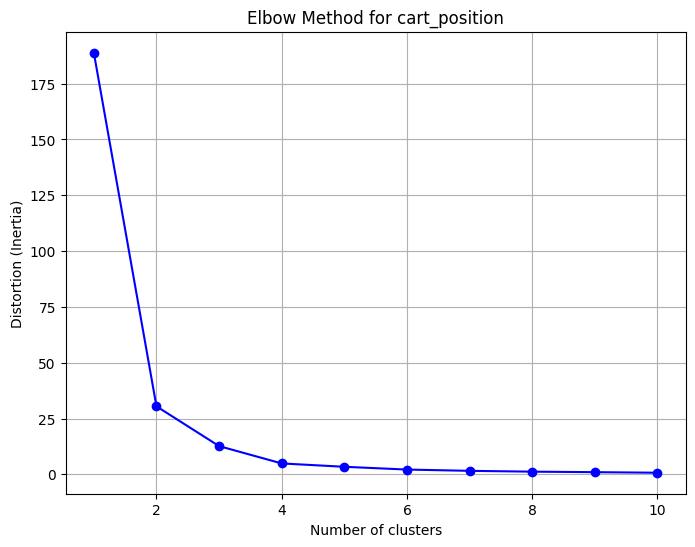

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

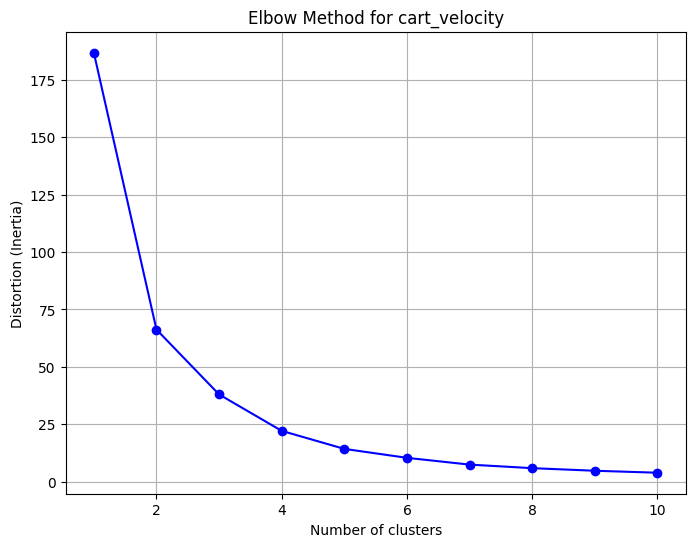

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

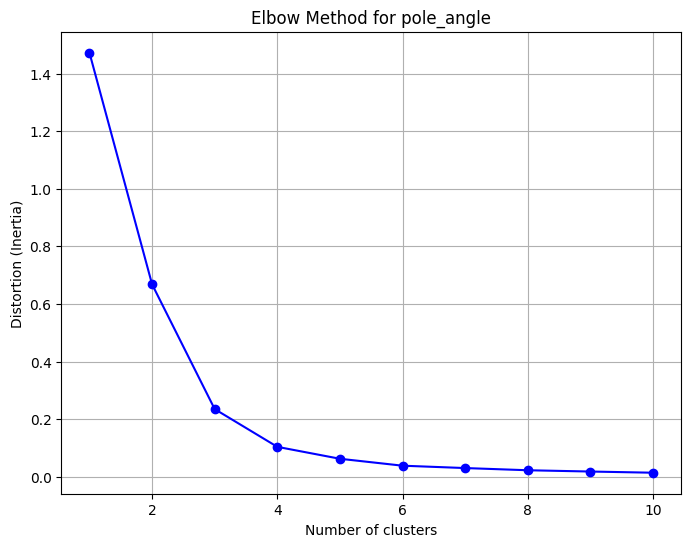

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

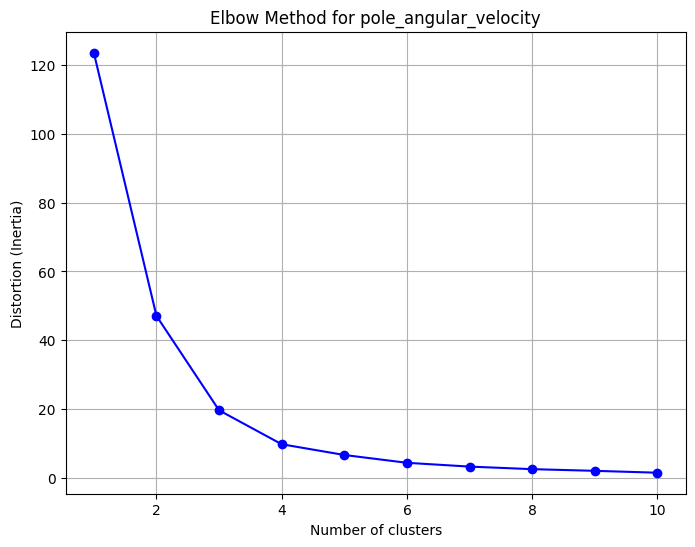

In [15]:
def elbow_method(data, var, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for'+f' {var}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.grid(True)
    plt.show()

    # Return the number of clusters and their corresponding distortions
    return list(range(1, max_clusters + 1)), distortions

col = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']
for c in col:
    clusters, distortions = elbow_method(data = data[[c]], var = c)


In [16]:
def kmeans_clustering(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels

bin_df = data.copy()
optimal_num_clusters = 6
for c in col:
    cluster_labels = kmeans_clustering(data[[c]], optimal_num_clusters)
    bin_df[c+'_bin'] = cluster_labels

/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/richtsai1103/bn_dqn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

In [17]:
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,cart_position_bin,cart_velocity_bin,pole_angle_bin,pole_angular_velocity_bin
104,1.472014,3.022731,-0.206378,-2.824556,2,5,2,2
172,0.807480,2.512567,-0.170164,-2.521953,4,1,2,2
258,1.286427,2.846230,-0.177349,-2.687675,2,5,2,2
372,1.962133,3.630681,-0.162776,-3.126369,3,5,2,2
461,1.321149,3.063333,-0.176627,-2.929144,2,5,2,2
...,...,...,...,...,...,...,...,...
2648,0.141579,0.306412,0.104700,0.311679,1,0,4,4
3630,0.832509,0.935115,0.069643,0.057704,4,0,0,3
7595,0.871737,0.734859,-0.000990,0.179033,4,0,3,3
6810,0.572105,0.507716,-0.025008,-0.021689,4,0,3,3


## Bin Threshold

In [18]:
thre_dic = {}
for c in col:
    var_name = c + '_bin'
    ls = []
    for i in range(optimal_num_clusters):   
        mini = min(list(bin_df[bin_df[var_name] == i][c]))
        ls.append(mini)
    ls = sorted(ls)
    threshold = {}
    for i in range(optimal_num_clusters):
        if i == 0:
            threshold[i] = (-math.inf, ls[i+1])
        elif i < optimal_num_clusters-1:
            threshold[i] = (ls[i], ls[i+1])
        else:
            threshold[i] = (ls[i], math.inf)
    thre_dic[c] = threshold
thre_dic

{'cart_position': {0: (-inf, 0.21811959),
  1: (0.21811959, 0.5721049),
  2: (0.5721049, 1.0856782),
  3: (1.0856782, 1.5744268),
  4: (1.5744268, 2.090134),
  5: (2.090134, inf)},
 'cart_velocity': {0: (-inf, -0.58112085),
  1: (-0.58112085, 0.30641216),
  2: (0.30641216, 1.0312582),
  3: (1.0312582, 1.7695595),
  4: (1.7695595, 2.7305381),
  5: (2.7305381, inf)},
 'pole_angle': {0: (-inf, -0.038930498),
  1: (-0.038930498, 0.031661827),
  2: (0.031661827, 0.07145579),
  3: (0.07145579, 0.118171096),
  4: (0.118171096, 0.16744451),
  5: (0.16744451, inf)},
 'pole_angular_velocity': {0: (-inf, -0.7264758),
  1: (-0.7264758, -0.15826607),
  2: (-0.15826607, 0.1931399),
  3: (0.1931399, 0.7395652),
  4: (0.7395652, 1.7246232),
  5: (1.7246232, inf)}}

In [19]:
for c in col:
    var_thre = thre_dic[c]
    ls = []
    for d in list(bin_df[c]):
        for i in range(optimal_num_clusters):
            var_clus_thre = var_thre[i]
            if d <= var_clus_thre[1] and d > var_clus_thre[0]:
                ls.append(i)
    bin_df[c] = ls
bin_df = bin_df[col]
bin_df 

,cart_position,cart_velocity,pole_angle,pole_angular_velocity
104,3,5,0,0
172,2,4,0,0
258,3,5,0,0
372,4,5,0,0
461,3,5,0,0
...,...,...,...,...
2648,0,1,3,3
3630,2,2,2,2
7595,2,2,1,2
6810,1,2,1,2


In [21]:
new_col = ['new_cart_position', 'new_cart_velocity', 'new_pole_angle', 'new_pole_angular_velocity']
next_data = ori_data[new_col]
next_data

,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
104,1.532469,3.218533,-0.262869,-3.172272
172,0.857732,2.708620,-0.220604,-2.861572
258,1.343351,3.042153,-0.231103,-3.028818
372,2.034747,3.436680,-0.225304,-2.886860
461,1.382416,3.259023,-0.235210,-3.269771
...,...,...,...,...
2648,0.147707,0.499899,0.110933,0.053764
3630,0.851212,0.739067,0.070798,0.371522
7595,0.886434,0.539752,0.002590,0.471404
6810,0.582259,0.312962,-0.025442,0.263000


In [22]:
next_bin = next_data.copy()
for c in col:
    var_new = 'new_'+ c
    var_thre = thre_dic[c]
    ls = []
    for d in list(next_data[var_new]):
        for i in range(optimal_num_clusters):
            var_clus_thre = var_thre[i]
            if d <= var_clus_thre[1] and d > var_clus_thre[0]:
                ls.append(i)
    next_bin[var_new] = ls
next_bin 

,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
104,3,5,0,0
172,2,4,0,0
258,3,5,0,0
372,4,5,0,0
461,3,5,0,0
...,...,...,...,...
2648,0,2,3,2
3630,2,2,2,3
7595,2,2,1,3
6810,2,2,1,3


In [23]:
bin_df = pd.concat([bin_df, next_bin], axis = 1)
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity
104,3,5,0,0,3,5,0,0
172,2,4,0,0,2,4,0,0
258,3,5,0,0,3,5,0,0
372,4,5,0,0,4,5,0,0
461,3,5,0,0,3,5,0,0
...,...,...,...,...,...,...,...,...
2648,0,1,3,3,0,2,3,2
3630,2,2,2,2,2,2,2,3
7595,2,2,1,2,2,2,1,3
6810,1,2,1,2,2,2,1,3


In [24]:
rew_act_df = ori_data[['reward', 'action']]
bin_df = pd.concat([bin_df, rew_act_df], axis=1)
bin_df

,cart_position,cart_velocity,pole_angle,pole_angular_velocity,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity,reward,action
104,3,5,0,0,3,5,0,0,0.0,1
172,2,4,0,0,2,4,0,0,0.0,1
258,3,5,0,0,3,5,0,0,0.0,1
372,4,5,0,0,4,5,0,0,0.0,0
461,3,5,0,0,3,5,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
2648,0,1,3,3,0,2,3,2,1.0,1
3630,2,2,2,2,2,2,2,3,1.0,0
7595,2,2,1,2,2,2,1,3,1.0,0
6810,1,2,1,2,2,2,1,3,1.0,0


In [25]:
bin_df.to_csv('sample_data.csv', index=False) 

## Dagma

### All data

In [4]:
df = pd.read_csv("bin_data.csv")
X = df.values
X

array([[0., 3., 1., ..., 4., 1., 0.],
       [0., 1., 1., ..., 4., 1., 0.],
       [0., 1., 1., ..., 5., 1., 0.],
       ...,
       [5., 5., 5., ..., 2., 1., 1.],
       [5., 5., 5., ..., 4., 1., 0.],
       [5., 5., 5., ..., 3., 0., 1.]])

### Sample Data

In [26]:
df = pd.read_csv("sample_data.csv")
X = df.values
X

array([[3., 5., 0., ..., 0., 0., 1.],
       [2., 4., 0., ..., 0., 0., 1.],
       [3., 5., 0., ..., 0., 0., 1.],
       ...,
       [2., 2., 1., ..., 3., 1., 0.],
       [1., 2., 1., ..., 3., 1., 0.],
       [0., 1., 1., ..., 2., 1., 0.]])

In [27]:
node_names_dict = {index: column_name for index, column_name in enumerate(df.columns)}
node_names_dict

{0: 'cart_position',
 1: 'cart_velocity',
 2: 'pole_angle',
 3: 'pole_angular_velocity',
 4: 'new_cart_position',
 5: 'new_cart_velocity',
 6: 'new_pole_angle',
 7: 'new_pole_angular_velocity',
 8: 'reward',
 9: 'action'}

In [28]:
eq_model = DagmaMLP(dims=[10, 10, 1], bias=True, dtype=torch.double) # create the model for the structural equations, in this case MLPs
model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
W_est = model.fit(X, lambda1=0.02, lambda2=0.005) 
W_est

100%|██████████| 230000/230000.0 [09:38<00:00, 397.68it/s]


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.91984906, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70436594,
        0.89162218, 0.97806465, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.63034249, 0.        , 0.        , 0.74216598,
        0.        , 0.76313921, 0.        , 0.        , 0.        ],
       [0.95080367, 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.32574505, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.92730238,
        0.        , 0.5476189 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.93272969, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

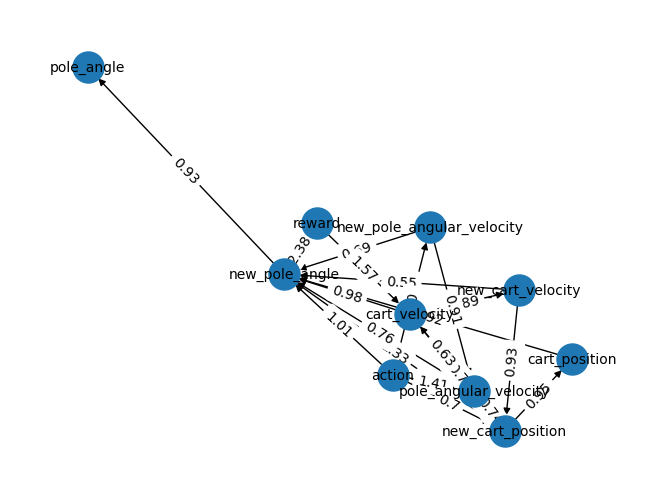

In [29]:
W_est = pd.DataFrame(W_est)
W_est = W_est.round(2)
# Create a directed graph (DiGraph)
G = nx.DiGraph()

# Add weighted edges based on the adjacency matrix
for row in range(W_est.shape[0]):
    for col in range(W_est.shape[1]):
        weight = W_est.iloc[row, col]
        if weight > 0:
            G.add_edge(row, col, weight=weight)

# Draw the graph
H = nx.relabel_nodes(G, node_names_dict)
pos = nx.spring_layout(H)  # Layout for visualization
edge_labels = {(u, v): d['weight'] for u, v, d in H.edges(data=True)}

# Draw the graph with custom node labels
nx.draw(H, pos, node_size=500, font_size=10, with_labels=True)

# Draw edge labels
nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)

plt.margins(0.1) 
plt.show()

In [40]:
W_est

,0,1,2,3,4,5,6,7,8,9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.0,0.0,0.0
1,0.00,0.00,0.00,0.00,0.70,0.89,0.98,0.0,0.0,0.0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
3,0.00,0.63,0.00,0.00,0.74,0.00,0.76,0.0,0.0,0.0
4,0.95,0.00,0.00,0.00,0.00,0.00,1.33,0.0,0.0,0.0
5,0.00,0.00,0.00,0.00,0.93,0.00,0.55,0.0,0.0,0.0
6,0.00,0.00,0.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0
7,0.00,0.00,0.00,0.91,0.00,0.00,0.69,0.0,0.0,0.0
8,0.00,1.57,0.00,0.00,0.00,0.00,2.38,0.0,0.0,0.0
9,0.00,0.00,0.00,1.41,0.70,0.00,1.01,1.0,0.0,0.0


In [49]:
W_est.to_csv('W_est.csv', index=False) 

## Bayesian Network

In [53]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

In [43]:
# Initialize the BayesianModel
model = BayesianNetwork()

for node in node_names_dict.values():
    model.add_node(node)

for child in range(len(W_est)):
    for parent in range(len(W_est)):
        if W_est[child][parent] != 0:
            model.add_edge(node_names_dict[parent], node_names_dict[child])

model.edges()

OutEdgeView([('cart_position', 'new_pole_angle'), ('cart_velocity', 'new_cart_position'), ('cart_velocity', 'new_cart_velocity'), ('cart_velocity', 'new_pole_angle'), ('pole_angular_velocity', 'cart_velocity'), ('pole_angular_velocity', 'new_cart_position'), ('pole_angular_velocity', 'new_pole_angle'), ('new_cart_position', 'cart_position'), ('new_cart_position', 'new_pole_angle'), ('new_cart_velocity', 'new_cart_position'), ('new_cart_velocity', 'new_pole_angle'), ('new_pole_angle', 'pole_angle'), ('new_pole_angular_velocity', 'pole_angular_velocity'), ('new_pole_angular_velocity', 'new_pole_angle'), ('reward', 'cart_velocity'), ('reward', 'new_pole_angle'), ('action', 'pole_angular_velocity'), ('action', 'new_cart_position'), ('action', 'new_pole_angle'), ('action', 'new_pole_angular_velocity')])

In [48]:
# CPD
mle = MaximumLikelihoodEstimator(model, df)
print(mle.estimate_cpd('cart_position')) 
print(mle.estimate_cpd('cart_velocity'))


+-------------------+-----+----------------------+
| new_cart_position | ... | new_cart_position(5) |
+-------------------+-----+----------------------+
| cart_position(0)  | ... | 0.0                  |
+-------------------+-----+----------------------+
| cart_position(1)  | ... | 0.0                  |
+-------------------+-----+----------------------+
| cart_position(2)  | ... | 0.0                  |
+-------------------+-----+----------------------+
| cart_position(3)  | ... | 0.0                  |
+-------------------+-----+----------------------+
| cart_position(4)  | ... | 0.019230769230769232 |
+-------------------+-----+----------------------+
| cart_position(5)  | ... | 0.9807692307692307   |
+-------------------+-----+----------------------+
+-----------------------+-----+--------------------------+
| pole_angular_velocity | ... | pole_angular_velocity(5) |
+-----------------------+-----+--------------------------+
| reward                | ... | reward(1.0)              |

In [50]:
model.fit(df, estimator=MaximumLikelihoodEstimator)

In [52]:
cart_velocity_cpd = model.get_cpds('cart_velocity')
print(cart_velocity_cpd)

+-----------------------+-----+--------------------------+
| pole_angular_velocity | ... | pole_angular_velocity(5) |
+-----------------------+-----+--------------------------+
| reward                | ... | reward(1.0)              |
+-----------------------+-----+--------------------------+
| cart_velocity(0)      | ... | 0.16666666666666666      |
+-----------------------+-----+--------------------------+
| cart_velocity(1)      | ... | 0.16666666666666666      |
+-----------------------+-----+--------------------------+
| cart_velocity(2)      | ... | 0.16666666666666666      |
+-----------------------+-----+--------------------------+
| cart_velocity(3)      | ... | 0.16666666666666666      |
+-----------------------+-----+--------------------------+
| cart_velocity(4)      | ... | 0.16666666666666666      |
+-----------------------+-----+--------------------------+
| cart_velocity(5)      | ... | 0.16666666666666666      |
+-----------------------+-----+-------------------------

## BN Prediction

In [54]:
# Initialize the inference object
inference = VariableElimination(model)

# Set evidence
evidence = {'cart_velocity': 0}

# Perform inference to predict the distribution of 'C' given the evidence
predicted_distribution = inference.query(variables=['new_cart_velocity'], evidence=evidence)
print(predicted_distribution)

+----------------------+--------------------------+
| new_cart_velocity    |   phi(new_cart_velocity) |
+======================+==========================+
| new_cart_velocity(0) |                   0.7143 |
+----------------------+--------------------------+
| new_cart_velocity(1) |                   0.2857 |
+----------------------+--------------------------+
| new_cart_velocity(2) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(3) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(4) |                   0.0000 |
+----------------------+--------------------------+
| new_cart_velocity(5) |                   0.0000 |
+----------------------+--------------------------+
